In [ ]:
import sys
sys.path.append('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders')


from get_data import get_data, get_data_train, get_data_val
import torch
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datasets import InMemDataLoader
import torch.nn.functional as F
import torch
import nibabel as nib     # Read / write access to some common neuroimaging file formats
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
from scipy import interpolate
import ot

import jmp_solver1.surrogates
import matplotlib
matplotlib.rcdefaults() 

from models_un import AE_un
from models import AE
from activations import Sin

: 

In [81]:
# All Functions 
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

# function to check whether the selected edge is going to close a potential loop

def expecting_a_cycle(actual_new_test, my_edge):

    left_ind = my_edge[0][0]
    right_ind = my_edge[0][1]
    found_right_ind = False
    going_nowhere= False

    new_test = actual_new_test

    tracker = 0
    no_branches_formed = True
    while (not(found_right_ind) or not(going_nowhere)):

        positions1 = (new_test == left_ind).nonzero(as_tuple=False)

        if(positions1.shape[0]>1):
            edge_to_delete = new_test[positions1[0][0]]
            no_branches_formed = False
        
        branches_rising = positions1.shape[0]

        if(positions1.shape[0]==0):
            going_nowhere= True
            if(no_branches_formed):
                break
            
            left_ind = my_edge[0][0]

            deletable_edge_position1 = (actual_new_test == edge_to_delete[0]).nonzero(as_tuple=False)
            deletable_edge_position2 = (actual_new_test == edge_to_delete[1]).nonzero(as_tuple=False)

            deletable_edge_position1 = deletable_edge_position1[:,0]

            deletable_edge_position2 = deletable_edge_position2[:,0]

            a_cat_b1, counts1 = torch.cat([deletable_edge_position1, deletable_edge_position2]).unique(return_counts=True)
            deletable_row_position = a_cat_b1[torch.where(counts1.gt(1))]

            if(deletable_row_position.shape[0]==0):
                going_nowhere = True
                break

            deletable_row_position = deletable_row_position[0]

            actual_new_test = torch.cat((actual_new_test[:deletable_row_position], actual_new_test[deletable_row_position+1:]))
            new_test = actual_new_test

            positions1 = (new_test == left_ind).nonzero(as_tuple=False)

            if(tracker ==0):
                break

        if(positions1.shape[0]>1):
            edge_to_delete = new_test[positions1[0][0]]
            no_branches_formed = False
                
        first_position = positions1[0][0]
        adj_edge1 = new_test[positions1[0][0]]
        other_end1 = abs(positions1 - torch.tensor([[0, 1]]))


        consec_pt1 = new_test[other_end1[0][0]][other_end1[0][1]]
        consec_pt1 = int(consec_pt1)

        if(consec_pt1 == right_ind):
            found_right_ind = True
            break

        else:
            left_ind = consec_pt1
            new_test = torch.cat((new_test[:first_position], new_test[first_position+1:]))
            tracker = tracker+1
    
    return found_right_ind


def get_zero_dim_persistent_homology(dist_matrix):
    
    dist_matrix = torch.unique(dist_matrix, dim=0)
    dist_matrix = torch.unique(dist_matrix, dim=1)

    upp_diag = torch.triu(dist_matrix, diagonal=1)

    ff = upp_diag.sort()

    sorted_upper_diag_edges = ff[0]

    sorted_upper_diag_indices = ff[1]

    flattened_uppdg_edges = torch.flatten(sorted_upper_diag_edges)

    non_zero_flattened_uppdg_edges = flattened_uppdg_edges[flattened_uppdg_edges.nonzero()]

    non_zero_flattened_uppdg_edges = non_zero_flattened_uppdg_edges.reshape(non_zero_flattened_uppdg_edges.shape[0])

    increasing_edges = non_zero_flattened_uppdg_edges.sort()[0]
    increasing_edges = torch.unique(increasing_edges, dim=0)
    
    #print('increasing_edges', increasing_edges)
    
    selected_edges = torch.tensor([])
    dead_indices = torch.tensor([])
    potential_triangles = torch.tensor([])
    edge_leads_to_loop = False

    for i in range(increasing_edges.shape[0]):
        a = (upp_diag == increasing_edges[i]).nonzero(as_tuple=False)

        if(selected_edges.shape[0] > 1):
            edge_leads_to_loop = expecting_a_cycle(selected_edges, a)

        if(not(edge_leads_to_loop)):
            selected_edges = torch.cat(((selected_edges, a)), 0)

    #print('selected_edges', selected_edges)
    zeroD_PH = torch.tensor([])
    for i in range(selected_edges.shape[0]):    
        death = dist_matrix[int(selected_edges[i][0])][int(selected_edges[i][1])]
        death = death.reshape(1,1)    
        zeroD_PH = torch.cat(((zeroD_PH, death)), 0)

    births = torch.zeros(zeroD_PH.shape[0], 1)
    zeroD_PH_births_deaths = torch.cat((births, zeroD_PH ),1)

    return selected_edges, zeroD_PH_births_deaths

    
def indices_array_any_size(m, n):
    r = np.arange(n)
    s = np.arange(m)
    out = np.empty((n,m,2),dtype=int)
    out[:,:,0] = r[:,None]
    out[:,:,1] = s
    output = out.reshape(m*n,2)
    output = torch.tensor(output).type(torch.FloatTensor)

    return output


#Computationally efficient than  previous method to calculate M 
def compute_M(img_indices, p=2):
    x = img_indices
    x_flat = x.view(x.size(0), -1)
    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)
    
    return distances**2


def wass_distance(image1,image2, M_matrix, reg):
    gs = ((image1 + 10**(-6)).reshape(M_matrix.shape[0],1)) / torch.sum((image1))
    h = ((image2 + 10**(-6)).reshape(M_matrix.shape[0],1)) / torch.sum((image2))
    # 10**(-10) added to avoid numerical errors in sinkhorn
    wassDistance = ot.sinkhorn2(h, gs, M_matrix, reg)
    #0.04 is the regularization parameter. You can play around with it 
    return wassDistance


In [10]:
# load trained rAE and bAE
latent_dims = [20, 18, 16, 14, 12, 10, 8, 6, 4, 2]
all_hyb_base_models = []

Analys_size = 20

all_test_coeffs = []
all_X_p = []
for lat_dim in latent_dims:
    deg_quad = 20
    u_ob = jmp_solver1.surrogates.Polynomial(n=deg_quad,p=np.inf, dim=2)
    x = np.linspace(-1,1,32)
    X_p = u_ob.data_axes([x,x]).T

    testImages = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/FMNIST_RK_coeffs/testImages.pt',map_location=torch.device('cpu'))
    testCoeffs = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/FMNIST_RK_coeffs/coeffs_saved/LSTSQ_testcoeffs_FMNIST_dq'+str(deg_quad)+'.pt',map_location=torch.device('cpu'))

    testImages = testImages[:Analys_size]
    testCoeffs = testCoeffs[:Analys_size]

    path_hyb = '/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/FMNIST_RK_space/output/MRT_full/test_run_saving/'
    path_unhyb = '/home/ramana44/FashionMNIST5LayersTrials/output/MRT_full/test_run_saving/'

    #specify hyperparameters
    reg_nodes_sampling = 'legendre'
    alpha = 0.5
    frac = 0.4
    hidden_size = 100
    deg_poly = 21
    deg_poly_forRK = 21
    latent_dim = lat_dim
    lr = 0.0001
    no_layers = 3
    no_epochs= 100
    name_hyb = '_'+reg_nodes_sampling+'_'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly_forRK)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)#+'_'+str(no_epochs)
    name_unhyb = '_'+reg_nodes_sampling+'__'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)#+'_'+str(no_epochs)

    inp_dim_hyb = (deg_quad+1)*(deg_quad+1)

    inp_dim_unhyb = [1,32,32]

    RK_model_reg = AE(inp_dim_hyb, hidden_size, latent_dim, no_layers, Sin()).to(device)
    #RK_model_base = AE(inp_dim_hyb, hidden_size, latent_dim, no_layers, Sin()).to(device)

    RK_model_reg.load_state_dict(torch.load(path_hyb+'model_regLSTQS'+str(deg_quad)+''+name_hyb, map_location=torch.device('cpu')))
    #RK_model_base.load_state_dict(torch.load(path_hyb+'model_baseLSTQS'+str(deg_quad)+''+name_hyb, map_location=torch.device('cpu')))

    all_hyb_base_models.append(RK_model_reg)
    all_test_coeffs.append(testCoeffs)
    all_X_p.append(X_p)


In [26]:
testImages.shape

torch.Size([20, 1, 32, 32])

In [12]:

all_rec_bAE_test = []
for i in range(len(latent_dims)):
    rec_bAE_test = all_hyb_base_models[i].encoder(all_test_coeffs[i].float())#.view(all_test_coeffs[i].shape)
    rec_bAE_test = torch.tensor(rec_bAE_test, requires_grad=False)
    all_rec_bAE_test.append(rec_bAE_test)

/tmp/ipykernel_50842/557051121.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_bAE_test = torch.tensor(rec_bAE_test, requires_grad=False)


In [13]:
latent_pt_cld = all_rec_bAE_test[0]

latent_pt_cld = latent_pt_cld[:40]

latent_pt_cld.shape

torch.Size([20, 20])

In [54]:
dist_matrix_lat1024 = _compute_distance_matrix(testImages, p=2)
edges_lat1024, edge_lengths_lat1024 = get_zero_dim_persistent_homology(dist_matrix_lat1024)

In [55]:
dist_matrix_lat20 = _compute_distance_matrix(all_rec_bAE_test[0], p=2)
edges_lat20, edge_lengths_lat20 = get_zero_dim_persistent_homology(dist_matrix_lat20)

In [57]:
dist_matrix_lat18 = _compute_distance_matrix(all_rec_bAE_test[1], p=2)
edges_lat18, edge_lengths_lat18 = get_zero_dim_persistent_homology(dist_matrix_lat18)

In [59]:
dist_matrix_lat16 = _compute_distance_matrix(all_rec_bAE_test[2], p=2)
edges_lat16, edge_lengths_lat16 = get_zero_dim_persistent_homology(dist_matrix_lat16)

In [63]:
dist_matrix_lat14 = _compute_distance_matrix(all_rec_bAE_test[3], p=2)
edges_lat14, edge_lengths_lat14 = get_zero_dim_persistent_homology(dist_matrix_lat14)

In [66]:
latent_dims

[20, 18, 16, 14, 12, 10, 8, 6, 4, 2]

In [85]:
#get image pixel indices combinations 
imageIndices_fmnist = indices_array_any_size(edges_lat1024.shape[0], edges_lat1024.shape[1])  #(145, 174)
##get matrix M , One time calculation of this matrix is sufficient. Same matrix could be
#used for similar image dimensions
M_fmnist = compute_M(imageIndices_fmnist, p=2)

In [87]:
all_MSEs = []
all_wass_dists = []
for i in range(len(latent_dims)):
    dist_matrix_lat = _compute_distance_matrix(all_rec_bAE_test[i], p=2)
    edges_lat, edge_lengths_lat = get_zero_dim_persistent_homology(dist_matrix_lat)
    mse = torch.mean(torch.sqrt((edges_lat1024 - edges_lat)**2))
    all_MSEs.append(mse)
    wasserstein_distance = wass_distance(edges_lat1024, edges_lat, M_fmnist, 0.09)
    all_wass_dists.append(wasserstein_distance)

/home/ramana44/.conda/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 541
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/ramana44/.conda/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/ramana44/.conda/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 532
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/ramana44/.conda/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 598
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/ramana44/.conda/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: nume

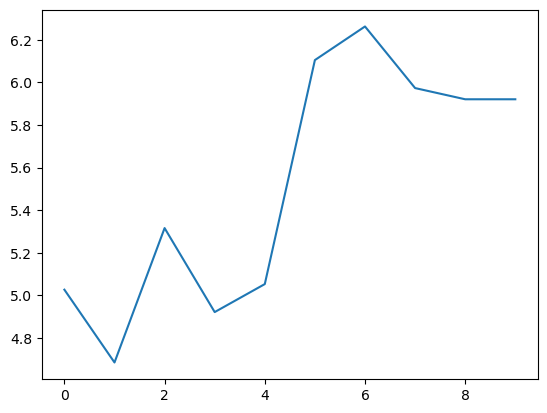

In [70]:
plt.plot(all_MSEs)

/home/ramana44/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/ramana44/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


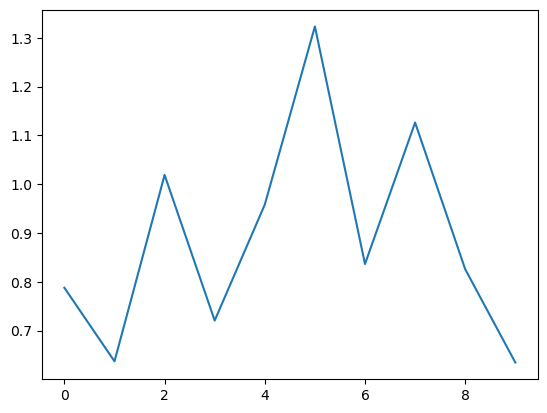

In [88]:
plt.plot(all_wass_dists)